## image generation
1. load transformer and vae
2. load prompt embedding generated by text encoders
3. generate latents on gpu
4. decode latents on cpu and display image

In [1]:
from typing import Any, Callable, Dict, List, Optional, Union

import torch
from diffusers import AutoencoderKL
from diffusers import SD3Transformer2DModel
from diffusers import FlowMatchEulerDiscreteScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers.image_processor import VaeImageProcessor

from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
num_images_per_prompt = 1
batch_size = 1

random_seed = True
if random_seed:
    generator = torch.manual_seed(torch.randn(1))
else:
    generator = torch.manual_seed(0)

In [2]:
model_id = "stabilityai/stable-diffusion-3-medium-diffusers"

vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
image_processor = VaeImageProcessor(vae_scale_factor=vae_scale_factor)

transformer = SD3Transformer2DModel.from_pretrained(model_id, subfolder="transformer")
transformer = transformer.eval()
transformer = transformer.to(device)

scheduler = FlowMatchEulerDiscreteScheduler(num_train_timesteps=1000, shift=3.0)

In [3]:
def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps

def prepare_latents(
    batch_size,
    num_channels_latents,
    height,
    width,
    dtype,
    device,
    generator,
    latents=None,
):
    if latents is not None:
        return latents.to(device=device, dtype=dtype)

    shape = (
        batch_size,
        num_channels_latents,
        int(height) // vae_scale_factor,
        int(width) // vae_scale_factor,
    )

    if isinstance(generator, list) and len(generator) != batch_size:
        raise ValueError(
            f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
            f" size of {batch_size}. Make sure the batch size matches the length of the generators."
        )

    latents = randn_tensor(shape, generator=generator, dtype=dtype)

    return latents

In [4]:
prompt_embeds, pooled_prompt_embeds = torch.load("final_emb.pt")
prompt_embeds = prompt_embeds.to(device)
pooled_prompt_embeds = pooled_prompt_embeds.to(device)

/tmp/ipykernel_6308/1390936704.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prompt_embeds, pooled_prompt_embeds = torch.load("final_emb.pt")


In [5]:
num_inference_steps = 28
height = 1024
width = 1024
guidance_scale = 7.0

timesteps = None

timesteps, num_inference_steps = retrieve_timesteps(scheduler, num_inference_steps, device, timesteps)
num_warmup_steps = max(len(timesteps) - num_inference_steps * scheduler.order, 0)

In [6]:
num_channels_latents = transformer.config.in_channels
latents = prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
)
latents = latents.to(device)
latents.shape

torch.Size([1, 16, 128, 128])

In [7]:
# the actual generation process
# with no optimizations, consumes 9500MiB vram at 1024x1024

with torch.no_grad():
    for i, t in tqdm(enumerate(timesteps)):
        latent_model_input = (torch.cat([latents] * 2))
        timestep = t.expand(latent_model_input.shape[0])
    
        noise_pred = transformer(
            hidden_states=latent_model_input,
            timestep=timestep,
            encoder_hidden_states=prompt_embeds,
            pooled_projections=pooled_prompt_embeds,
            joint_attention_kwargs=None,
            return_dict=False,
        )[0]
    
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents_dtype = latents.dtype
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

28it [01:48,  3.87s/it]


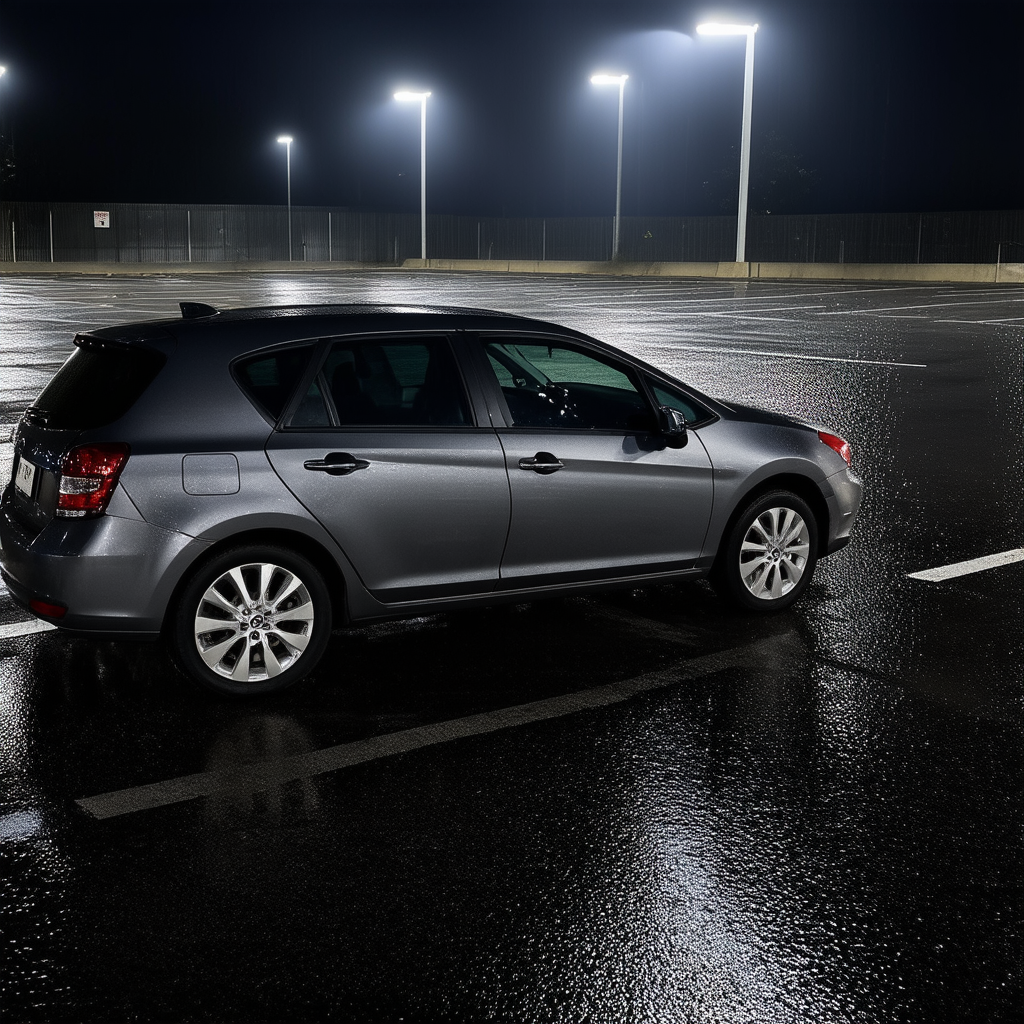

In [8]:
# decode the latents on cpu

latents = latents.to("cpu")
latents = (latents / vae.config.scaling_factor) + vae.config.shift_factor

with torch.no_grad():
    image = vae.decode(latents, return_dict=False)[0]
    image = image_processor.postprocess(image, output_type="pil")

display(image[0])